# База "ключ-значение" Redis

Давайте потестируем производительность БД Redis, которая относится к базам "ключ-значение" и позиционируется как одна из самых быстрых баз данных.

Документация на обертку для Питона находится [здесь](https://redis-py.readthedocs.io/en/stable/genindex.html).

Установим саму базу данных и redis-py (`pip3 install redis`). Помимо этого установим библиотеку hiredis (`pip3 install hiredis`), которая обрабатывает ответ от БД несколько быстрее.

Воспользуемся тем, что Mongo и bson у нас уже установлены<sup>\*</sup>. Будем генерировать уникальные идентификаторы при помощи ObjectId.
<hr>
<sup>*</sup> По-крайней мере, у меня. Если кто-либо хочет синхронизироваться, пусть поставит библиотеку для работы с Mongo - <a href="http://api.mongodb.com/python/current/api/index.html">pymongo</a>.

In [1]:
# Импортируем драйвер к Redis.
import redis
from bson import ObjectId
import datetime
import time

Код в ячейке ниже поможет нам визуализировать нашу работу с Redis.

In [7]:
from ipywidgets import HTML

def show_redis_data(r):
    html = HTML()
    out = '<table border="1">'
    for key in r.keys():
        t = r.type(key).decode()
#         print(key.decode(), t)
        
        if t == 'string':
            data = r.get(key)
            out += f'<tr><td style="padding:3px;width:150px;">{key.decode()}</td>'\
                   f'<td style="padding:3px;width:50px;">string</td>'\
                   f'<td style="padding:3px;">{data.decode()}</td></tr>'
        elif t == 'list':
            l = r.llen(key)
            data = r.lrange(key, 0, l)
            out += f'<tr><td style="padding:3px;width:150px;">{key.decode()}</td>'\
                   f'<td style="padding:3px;width:50px;">list</td>'\
                   f'<td style="padding:3px;">[{", ".join([d.decode() for d in data])}]</td></tr>'
        elif t == 'hash':
            data = []
            for key2 in r.hkeys(key):
                data.append(f'{key2.decode()}: {r.hget(key, key2).decode()}')
            out += f'<tr><td style="padding:3px;width:150px;">{key.decode()}</td>'\
                   f'<td style="padding:3px;width:50px;">hash</td>'\
                   f'<td style="padding:3px;">{{{", ".join(data)}}}</td></tr>'
        elif t == 'set':
            data = r.smembers(key)
            out += f'<tr><td style="padding:3px;width:150px;">{key.decode()}</td>'\
                   f'<td style="padding:3px;width:50px;">set</td>'\
                   f'<td style="padding:3px;">({", ".join([d.decode() for d in data])})</td></tr>'
        
    out += '</table>'
    
    html.value = out
    display(html)


Присоединяемся к базе данных. По умолчанию она работает только с локальной машиной, аутентификация не предусмотрена.

На самом деле, параметры можно не указывать, ниже передаются те же самые значения, что принимаются по умолчанию.

In [3]:
r = redis.Redis(host='localhost', port=6379, db=0)

Очистим базу, чтобы нам ничего не мешало.

In [4]:
r.flushdb()

True

Попробуем положить какой-нибудь ключ...

In [5]:
r.set('foo', 'bar2')
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">foo</td><td style="padding:3px;width:50…

... и получить его обратно.

In [6]:
r.get('foo')

b'bar2'

In [7]:
ttt = r.get('foo')

In [8]:
ttt.decode()

'bar2'

Обратите внимание, что все данные превращаются в строки, хотя мы можем присваивать их как числа.  
Также обратите внимание, что если Redis находит ключ, то он заменяет его значение, а если не находит, то заводит в базе новый ключ и связывает с ним значение.

In [9]:
r.set('foo', 100)
print(r.get('foo'), type(r.get('foo')))
print(int(r.get('foo')))
r.set('another one', 200)

show_redis_data(r)

b'100' <class 'bytes'>
100


HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">another one</td><td style="padding:3px;…

При помощи функции `keys` можно посмотреть все ключи в базе. Функция `flushdb` очищает текущую базу.

In [10]:
r.keys()

[b'another one', b'foo']

Померим скорость работы с базой при помощи такого простого метода, как `set`. Положим в базу 100 000 уникальных ключей, к которым привязано одно целое число.

ObjectId по умолчанию генерирует некоторый уникальный ключ. В дальнейшем мы будем преобразовывать его к строке и использовать как уникальный ключ для наших данных.

In [11]:
ObjectId(), str(ObjectId())

(ObjectId('619522799152c1dd9c7c77f2'), '619522799152c1dd9c7c77f3')

In [12]:
%%time
for i in range(100000):
    r.set(str(ObjectId()), i)
#    r.set(i, i)


CPU times: user 2.82 s, sys: 1.38 s, total: 4.2 s
Wall time: 8.04 s


Примерно 12 000 операций вставки в секунду на локальной машине. Не так уж и много.

Посмотрим с какой скоростью они будут читаться.

In [13]:
%%time
summ=0
for k in r.keys():
    summ += int(r.get(k))

print("Всего ключей:", r.dbsize())

Всего ключей: 100002
CPU times: user 1.85 s, sys: 1.43 s, total: 3.27 s
Wall time: 6.94 s


Около 14 000 операций чтения.

Хм... Этот Redis, кажется, не такой уж и молодец.

Или мы что-то делаем не так? Давайте сравним с `dict`.

In [14]:
%%time
tst_dct={}
for i in range(100000):
    tst_dct[str(ObjectId())]=i

CPU times: user 194 ms, sys: 4.19 ms, total: 198 ms
Wall time: 197 ms


Примерно 500 000 операций записи в секунду...

In [15]:
%%time
summ=0
for k in tst_dct.keys():
    summ+=int(tst_dct[k])

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 15.3 ms


... и примерно 5 млн операций чтения в секунду. Пока Redis очень далеко до `dict`.

Хотя dict не умеет отдавать данные нескольким программам одновременно.

### Автоматическое удаление ключей из базы по таймауту

Давайте пока посмотрим что Redis  умеет еще. Например, при помощи функции `expire` каждой паре можно сказать, что она утрачивает актуальность через какое-то время. 

Положим в базу 100 000 ключей, каждому из них установим время жизни 10 секунд, уснём на 15 секунд и посмотрим что осталось в базе.

In [16]:
r.flushdb()

for i in range(100000):
    oid=str(ObjectId())
    r.set(oid, i)
    r.expire(oid, 10)

time.sleep(15)

summ=0
for k in r.keys():
    summ+=int(r.get(k))
    
print(r.dbsize(), summ)

0 0


In [17]:
print(r.get(oid))

None


Как видно, не осталось ничего. Метод работает.

Помимо работы с простыми числами, Redis позволяет организовывать список, привязанный к определенному ключу. При помощи функций `rpush` и `lpush` можно класть значения в очередь с заданным ключем.

In [18]:
r.set('test1', 1) # Просто, чтобы было видно отличие.
r.lpush('test2', 2) # Первый элемент.
r.rpush('test2', 3) # Следующий кладется справа.
r.lpush('test2', 4) # Следующий кладется слева.
r.rpush('test2', 5) # Последний кладется справа.
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">test2</td><td style="padding:3px;width:…

In [19]:
# Можно в одну операцию достать элемент и тот же положить его обратно.
d = r.rpoplpush('test2', 'test2')
print(d)
show_redis_data(r)

b'5'


HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">test2</td><td style="padding:3px;width:…

Попробуем замерить скорость работы при помощи списков.

In [20]:
%%time
for i in range(100000):
    r.lpush('firstkey', i)
    r.lpush('secondkey', i)
    
print(r.keys())

[b'firstkey', b'test2', b'test1', b'secondkey']
CPU times: user 4.3 s, sys: 2.82 s, total: 7.12 s
Wall time: 14.7 s


Заодно проверим, может быть добавление ключей с другой стороны будет быстрее.

In [21]:
r.flushdb()

True

In [22]:
%%time
for i in range(100000):
    r.rpush('firstkey', i)
    r.rpush('secondkey', i)
    
print(r.keys())

[b'firstkey', b'secondkey']
CPU times: user 4.36 s, sys: 2.84 s, total: 7.2 s
Wall time: 14.9 s


Получается еще медленнее, чем при помощи `set`.

Извлекаем данные при помощи `lpop` и `rpop`. Как видно, получается тоже не быстро.

In [23]:
%%time
for i in range(100000):
    r.lpop('firstkey')
    r.lpop('secondkey')

CPU times: user 3.62 s, sys: 2.8 s, total: 6.42 s
Wall time: 13.8 s


Теперь попробуем пакетную запись значений. 

Может быть генерация ключей занимает больше времени, чем работа с БД? Отдельно сгенерируем идентификаторы для ключей, а потом положим их в базу.

In [24]:
%%time
objs=[str(ObjectId()) for i in range(100000)]

CPU times: user 161 ms, sys: 0 ns, total: 161 ms
Wall time: 161 ms


In [25]:
%%time
for i,x in enumerate(objs):
    r.set(x, i)

CPU times: user 2.1 s, sys: 1.48 s, total: 3.58 s
Wall time: 7.44 s


Быстрее не вышло. Может быть дело в for, и с помощью map мы сделаем всё быстрее?

In [26]:
%%time
_=list(map(lambda x: r.set(x[1], x[0]), enumerate(objs)))

CPU times: user 2.33 s, sys: 1.42 s, total: 3.74 s
Wall time: 7.67 s


Убедимся, что мы не забыли сгенерировать новые ключи перед запуском предыдущей ячейки - проверим количество ключей в базу.

In [27]:
r.dbsize()

100000

Также убедимся, что работа со словарем всё еще быстрее. Кстати, значительно быстрее генерации ключей.

In [28]:
%%time
tst_dct = {}
for i in enumerate(objs):
    tst_dct[x] = i

CPU times: user 9.31 ms, sys: 393 µs, total: 9.7 ms
Wall time: 9.67 ms


Ключи в самом деле лежат в базе?

In [29]:
list(r.keys())[:10]

[b'619522d29152c1dd9c826444',
 b'619522d29152c1dd9c8167e1',
 b'619522d29152c1dd9c8136ce',
 b'619522d29152c1dd9c828fd7',
 b'619522d29152c1dd9c8241a6',
 b'619522d29152c1dd9c81feae',
 b'619522d29152c1dd9c82136f',
 b'619522d29152c1dd9c81b16e',
 b'619522d29152c1dd9c819850',
 b'619522d29152c1dd9c81c250']

Попробуем функцию `mset`, которая кладет всё содержимое словаря одновременно.

In [30]:
%%time
objs={str(ObjectId()):i for i in range(100000)}

CPU times: user 175 ms, sys: 1.04 ms, total: 176 ms
Wall time: 177 ms


In [31]:
%%time
r.mset(objs)

CPU times: user 196 ms, sys: 960 µs, total: 197 ms
Wall time: 262 ms


True

In [32]:
mkeys = list(r.keys())[:1000]

In [33]:
%%time
_ = r.mget(mkeys)

CPU times: user 2.03 ms, sys: 0 ns, total: 2.03 ms
Wall time: 2.06 ms


Получается в несколько раз быстрее - около 250 000 ключей в секунду. Но это всё еще не похоже на миллион запросов в секунду.

### Замер производительности Redis в несколько потоков

Хорошо, может быть это Питон не справляется, а база может работать быстрее? Попробуем запустить несколько потоков, которые пишут в базу. Оформим генерацию ключей и загрузку ключей в базу как отдельную функцию, чтобы можно было ее запускать в параллельных потоках.

In [3]:
import multiprocessing

In [35]:
def putKey2Redis():
    objs={str(ObjectId()):i for i in range(100000)}
    #_=list(map(lambda x: r.set(x[1], x[0]), enumerate(objs)))
    r.mset(objs)

In [36]:
%%time
pr = []

for i in range(10):
    p = multiprocessing.Process(target=putKey2Redis)
    p.start()
    pr.append(p)

for p in pr:
    p.join()

CPU times: user 4.16 ms, sys: 31.9 ms, total: 36.1 ms
Wall time: 1.88 s


500 000 запросов в секунду. Явно улучшение не в 10 раз. Значит дело не только в Питоне. Но скорость уже впечатляющая. От обычной БД с настройками из коробки такую скорость не получишь.

### Хеш-массивы

Redis умеет привязывать к ключу хешированный массив - аналог питоновского словаря. Запись одного значения производится по паре ключ-ключ внутри хеша при помощи `hset`, чтение - аналогично при помощи `hget`.


In [37]:
r.flushdb()
r.hset('asdf', '1', '200')
r.hset('asdf', '2', '201')

1

In [38]:
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">asdf</td><td style="padding:3px;width:5…

In [39]:
r.hget('asdf', '2')

b'201'

Как и в случае со скалярными значениями, найденный ключ перезаписывается.

In [40]:
r.hset('asdf', '2', '301')

show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">asdf</td><td style="padding:3px;width:5…

Проверить наличие ключа в хеше можно при помощи функции `hexists`.

In [41]:
r.hexists("asdf","33")

False

Померяем скорость работы с Redis с хешами. Попробуем класть его при помощи функции `hmset` (h - хешированный. m - много ключей сразу).

In [42]:
r.flushdb()

True

In [43]:
import threading

In [44]:
def putKey2Redis2(my_key):
    objs={str(ObjectId()):i for i in range(100000)}
    print(my_key, list(objs.keys())[:2])
    r.hset(my_key, mapping=objs)

In [45]:
%%time
pr=[]

for i in range(10):
#     p=multiprocessing.Process(target=putKey2Redis2, args=['hash_key'+str(i)])
    p=threading.Thread(target=putKey2Redis2, args=['hash_key'+str(i)])
    p.start()
    pr.append(p)

for p in pr:
    p.join()

hash_key0 ['619522e49152c1dd9c841914', '619522e49152c1dd9c841915']
hash_key4 ['619522e49152c1dd9c843997', '619522e49152c1dd9c84399f']
hash_key2 ['619522e49152c1dd9c843990', '619522e49152c1dd9c843994']
hash_key7 ['619522e49152c1dd9c8439a9', '619522e49152c1dd9c8439b4']
hash_key8 ['619522e49152c1dd9c8439a3', '619522e49152c1dd9c8439ad']
hash_key9 ['619522e49152c1dd9c8439a5', '619522e49152c1dd9c8439af']
hash_key1 ['619522e49152c1dd9c84397c', '619522e49152c1dd9c84398c']
hash_key3 ['619522e49152c1dd9c843993', '619522e49152c1dd9c843998']
hash_key5 ['619522e49152c1dd9c843999', '619522e49152c1dd9c8439a1']
hash_key6 ['619522e49152c1dd9c84399d', '619522e49152c1dd9c84399e']
CPU times: user 12.9 s, sys: 7.59 s, total: 20.5 s
Wall time: 14 s


In [46]:
r.keys()

[b'hash_key4',
 b'hash_key2',
 b'hash_key0',
 b'hash_key9',
 b'hash_key5',
 b'hash_key3',
 b'hash_key1',
 b'hash_key6',
 b'hash_key8',
 b'hash_key7']

In [47]:
r.hget('hash_key4', '616d3caf9b101bb49a1083c3')

In [48]:
r.hset("test_key", mapping={"c":3})

1

In [49]:
r.hset("test_key", mapping={"a":1, "b":2})

2

In [50]:
r.hget("test_key", "c")

b'3'

In [51]:
r.hmget("test_key", ["a", "b", "c", "d"])

[b'1', b'2', b'3', None]

In [52]:
r.hset("test_key", mapping={"c":"{'s':'d'}"})

0

In [53]:
r.hget("test_key", "c")

b"{'s':'d'}"

In [54]:
r.hmget("test_key",['a','c'])

[b'1', b"{'s':'d'}"]

In [55]:
r.hkeys("test_key")

[b'c', b'a', b'b']

Увеличения скорости не наблюдается.

При помощи функции `hkeys` можно получить ключи для конкретного хеш-массива. `hmget` позволяет получить значения по нескольким ключам.

In [56]:
r.flushdb()

True

In [57]:
%%time
objs={str(ObjectId()):i for i in range(100000)}

CPU times: user 161 ms, sys: 0 ns, total: 161 ms
Wall time: 159 ms


In [58]:
%%time
r.hset("longkey", mapping=objs)

CPU times: user 224 ms, sys: 0 ns, total: 224 ms
Wall time: 263 ms


100000

In [59]:
ho=r.hkeys("longkey")

In [60]:
ho[:10]

[b'619522f39152c1dd9c9380fa',
 b'619522f39152c1dd9c9397e3',
 b'619522f39152c1dd9c94679e',
 b'619522f39152c1dd9c93db65',
 b'619522f39152c1dd9c94a8f8',
 b'619522f39152c1dd9c944d03',
 b'619522f39152c1dd9c94ba06',
 b'619522f39152c1dd9c946f10',
 b'619522f39152c1dd9c94b0bf',
 b'619522f39152c1dd9c94dce0']

In [61]:
%%time
oo=r.hmget("longkey", ho[:10])

CPU times: user 1.14 ms, sys: 0 ns, total: 1.14 ms
Wall time: 811 µs


In [62]:
oo

[b'9638',
 b'15503',
 b'68682',
 b'32785',
 b'85412',
 b'61871',
 b'89778',
 b'70588',
 b'87403',
 b'98700']

Можно убедиться еще раз, что работа со списком ключей гораздо быстрее, чем получение значений по ключу по отдельности.

In [63]:
%%time
for k in ho:
    _=r.hget("longkey", k)

CPU times: user 1.91 s, sys: 1.47 s, total: 3.39 s
Wall time: 7.28 s


In [64]:
%%time
oo=r.hmget("longkey", ho)

CPU times: user 74 ms, sys: 0 ns, total: 74 ms
Wall time: 91.4 ms


### Блокирующие операции в Redis

Redis поддерживает блокирующие операции. При помощи `brpop` и `blpop` мы можем приостановить свои действия либо пока не будет получено значение, либо пока не пройдет заданный промежуток времени.

Если функция успешно получила значение, она вернет его без дальнейшего ожидания. Если значение не было получено, то по истечении таймаута функция вернет None.

В примере ниже мы вынуждены сперва класть данные, а потом получать их без ожидания (ведь они уже есть в базе), так как мы работаем в один поток.

In [65]:
r.rpush("blockedTest", "asdf")
print(r.brpop("blockedTest", 1))

(b'blockedTest', b'asdf')


Если работать в два потока (один пишет, второй читает), становится видно, что управление возвращается после ожидания в блокирующей функции.

In [66]:
# Функция ждет 5 секунд и только тогда пишет данные в базу.
def blockingWrite():
    time.sleep(5)
    r.lpush("blockedTest", "Yahooo!")
    
# Функция пытается читать данные, и если возвращается None (данные не пришли в течение таймаута),
# то она повторяет попытки до успешного чтения.
def blockingRead():
    bres = r.brpop("blockedTest", 1)
    while bres == None:
        print("waiting")
        bres = r.brpop("blockedTest", 1)
    print(bres)
    
bpr1=multiprocessing.Process(target=blockingWrite)
bpr2=multiprocessing.Process(target=blockingRead)
bpr1.start()
bpr2.start()
bpr1.join()
bpr2.join()

waiting
waiting
waiting
waiting
(b'blockedTest', b'Yahooo!')


### Множества

Помимо этого, к ключу можно привязать множество. Добавление в множество ведется при помощи операции `sadd`. Также можно находить пересечение (`sinter`), объединение (`sunion`)  разницу (`sdiff`) множеств.

In [67]:
r.flushdb()

True

In [68]:
r.sadd("testSets1", "A")
r.sadd("testSets1", "B")
r.sadd("testSets1", "C")

r.sadd("testSets2", "A")
r.sadd("testSets2", "D")
r.sadd("testSets2", "F")

print('intersection:', r.sinter(["testSets1","testSets2"]))

show_redis_data(r)

intersection: {b'A'}


HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">testSets2</td><td style="padding:3px;wi…

Результаты операций над множествами можно сохранить в другое множество.

In [69]:
r.sdiffstore("testSets4", ["testSets1", "testSets2"])
r.sunionstore("testSets3", ["testSets1", "testSets2"])
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">testSets3</td><td style="padding:3px;wi…

Элемент можно атомарно перебросить из одного множества в другое при помощи `smove`.

In [70]:
r.smove("testSets2", "testSets1", 'F')
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">testSets3</td><td style="padding:3px;wi…

 Удалить значение можно при помощи `srem`, узнать длину множества - `scard`.

In [71]:
r.srem("testSets1", 'F')
show_redis_data(r)
print(r.scard("testSets1"))

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">testSets3</td><td style="padding:3px;wi…

3


### Последовательности команд и имитация транзакций

Каждая команда возвращает объект типа `pipeline`. Данный объект позволяет выполнять транзакции. Для этого необходимо при помощи pipeline выполнить несколько команд (они будут поставлены во внутреннюю очередь), а затем вызвать `execute`. Таким образом поддерживаются транзакции для нескольких команд, не требующих промежуточного чтения результатов.

В итоге вернется список результатов выполнения команд.

In [72]:
pipe=r.pipeline()
pipe.srem("testSets1", 'A')
pipe.sadd("testSets1", 'G')
pipe.smembers("testSets1")
pipe.execute()

[1, 1, {b'B', b'C', b'G'}]

In [73]:
r.pipeline().srem("testSets2", 'A').sadd("testSets1", 'R').smembers("testSets1").execute()

[1, 1, {b'B', b'C', b'G', b'R'}]

Если в промежутках необходимо модифицировать какие-то значения, следует использовать следующую конструкцию. В ней `watch` говорит, что мы будем следить за заданным ключем. Команда `multi` говорит о том, что сейчас будет выполняться несколько операций как транзакция. Если значение, связанное с ключем в `watch` изменилось до начала `execute` (выполнение нескольких операций), то будет вызвано исключение.

In [74]:
ppp=r.pipeline()
ppp.multi()
ppp.set("dummy1", "1")
#ppp.multi()
ppp.set("dummy2", "1")
ppp.execute()

[True, True]

In [75]:
r.get("dummy1")

b'1'

Собственно транзакций в Redis не предусмотрено. Вместо этого можно подписаться на изменения какого-то ключа. Если ключ изменился в ходе наших вычислений, значит надо начать операцию заново. Довести операцию до конца получится только если прерывание не произошло, то есть никто не перезаписывал важные для нас данные.

In [76]:
r.set('OUR-SEQUENCE-KEY', 1)
with r.pipeline() as pipe:
    while 1:
        try:
            pipe.watch('OUR-SEQUENCE-KEY')
            current_value = pipe.get('OUR-SEQUENCE-KEY')
            next_value = int(current_value) + 1
            pipe.multi()
            pipe.set('OUR-SEQUENCE-KEY', next_value)
            pipe.execute()
            break
        except redis.WatchError:
            continue
            
r.get('OUR-SEQUENCE-KEY')

b'2'

А еще у Redis замечательные [битовые операции](https://blog.getspool.com/2011/11/29/fast-easy-realtime-metrics-using-redis-bitmaps/) и отсортированные списки.

---

## Применение Redis для хранения сложных объектов

Наличие хеш-массивов фактически позволяет хранить в базе данных объекты/словари/JSON и обращаться к ним при помощи уникальных ключей. Правда, плохо получается хранить в полях таких объектов массивы других объектов. Традиционно для таких задач склеивают последовательность ключей в один, используя в качестве разделителя двоеточие. Таким образом, вместо того, чтобы хранить список объектов, мы храним много уникальных ключей, которые известным образом можно соотнести с объектами.

Попробуем решить следующую задачу.

Есть квадратная карта заданного размера. На карте находятся растения, деревья, травоядные и хищники. Необходимо промоделировать поведение системы, обеспечивая обмен данными между частями модели через Redis. 

In [77]:
import random

In [78]:
r = redis.Redis(host='localhost', port=6379, db=0)

In [79]:
r.flushdb()

True

In [80]:
world = {"sizeX":50, "sizeY":50, "iniPred":5, "iniCarn":20, 
         "lifeExpPred":10, "lifeExpPredStd":3, "breedPeriodPred":4, "lifePredMin":50, "lifePredMax":100,  
         "lifeExpCarn":10, "lifeExpCarnStd":3, "breedPeriodCarn":3, "lifeCarnMin":50, "lifeCarnMax":100, 
         "herbCount":10000, "treesCount":500, 
         "lifeExpTree":30, "lifeExpTreeStd":5, "breedPeriodTree":6}

r.hset("worldDescription", mapping=world)
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">worldDescription</td><td style="padding…

У тайлов заводим свойство "количество растений в тайле".

In [81]:
tile={"herbs": 0}
for i in range(world["sizeY"]):
    for j in range(world["sizeX"]):
        r.hset("tile:"+str(i+1)+":"+str(j+1), mapping=tile)
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">tile:24:21</td><td style="padding:3px;w…

Раскидываем растения по тайлам, увеличивая число растений в выбранном тайле.

In [82]:
for i in range(world["herbCount"]):
    x=random.randint(1, world["sizeX"])
    y=random.randint(1, world["sizeY"])
    r.hincrby("tile:"+str(y)+":"+str(x), "herbs", 1)
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">tile:50:36</td><td style="padding:3px;w…

In [83]:
for i in range(world["iniCarn"]):
    g = random.randint(0, 1)
    x = random.randint(1, world["sizeX"])
    y = random.randint(1, world["sizeY"])
    carn={"x":str(x), "y":str(y), 
          "carn_id":str(ObjectId()), "carn_age":0, "carn_gender": g,
          "carn_life_exp": random.randint(world["lifeExpCarn"]-world["lifeExpCarnStd"], world["lifeExpCarn"]+world["lifeExpCarnStd"]), 
          "carn_hunger":0,
          "carn_life":random.randint(world["lifeCarnMin"], world["lifeCarnMax"])
         }
    r.lpush("tile:"+str(x)+":"+str(y)+":carns", carn["carn_id"])
    r.hset("carn:"+carn["carn_id"], mapping=carn)
    r.lpush("carns_id", carn["carn_id"])

In [84]:
for i in range(world["iniPred"]):
    x = random.randint(1, world["sizeX"])
    y = random.randint(1, world["sizeY"])
    g=random.randint(0, 1)
    pred={"x":str(x), "y":str(y), 
          "pred_id":str(ObjectId()), "pred_age":0, "pred_gender": g,
          "pred_life_exp": random.randint(world["lifeExpPred"]-world["lifeExpPredStd"], world["lifeExpPred"]+world["lifeExpPredStd"]), 
          "pred_hunger":0,
          "pred_life":random.randint(world["lifePredMin"], world["lifePredMax"])
         }
    r.lpush("tile:"+str(x)+":"+str(y)+":preds", pred["pred_id"])
    r.hset("pred:"+pred["pred_id"], mapping=pred)
    r.lpush("preds_id", pred["pred_id"])
    
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">tile:50:36</td><td style="padding:3px;w…

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('ggplot')
#plt.style.use('classic')
plt.rcParams['figure.figsize'] = (12, 8)

In [86]:
def showIt(field, who, c_len, s):
    for i in range(c_len):
        c_id = r.rpoplpush(who+"s_id", who+"s_id").decode()
        cx = int(r.hget(who+":"+c_id, "x"))
        cy = int(r.hget(who+":"+c_id, "y"))
        #print("pred:"+p_id, cx, cy)
        field[cy-1][cx-1] = s

def showField():
    sx = int(r.hget("worldDescription", "sizeX"))
    sy = int(r.hget("worldDescription", "sizeY"))
    
    carn_len=r.llen("carns_id")
    pred_len=r.llen("preds_id")
    field=[[0 for j in range(sx)] for i in range(sy)]
    for i in range(sy):
        for j in range(sx):
            try:
                field[i][j] = int(r.hget("tile:"+str(i+1)+":"+str(j+1),"herbs"))
            except Exception:
                print("Except:", i, j, r.hget("tile:"+str(i+1)+":"+str(j+1),"herbs"))
    
    """for i in range(sx):
        for j in range(sy):
            herb_cnt=r.hget("tile:"+str(i+1)+":"+str(j+1), "herbs")
            field[i][j]=herb_cnt.decode()""";
    
    showIt(field, "pred", pred_len, 10)
    showIt(field, "carn", carn_len, 12)

    ax = plt.subplot()
    ax.imshow(field);

        
def moveIt(who, c_id, sx, sy):
    #print(who+":"+c_id, r.hget(who+":"+c_id, "x"), r.hget(who+":"+c_id, "y"))
    cx = int(r.hget(who+":"+c_id, "x"))
    cy = int(r.hget(who+":"+c_id, "y"))
    
    while True:
        _cx=cx+random.randint(-1, 1)
        _cy=cy+random.randint(-1, 1)
        if _cx>=1 and _cx<=sx and _cy>=1 and _cy<=sy:
            break
    r.hset(who+":"+c_id, "x", _cx)
    r.hset(who+":"+c_id, "y", _cy)
    r.lrem("tile:"+str(cx)+":"+str(cy)+":"+who+"s", 0, c_id)
    r.lpush("tile:"+str(_cx)+":"+str(_cy)+":"+who+"s", c_id)

    return cx, cy, _cx, _cy
    

def moveCarns():
    carn_len=r.llen("carns_id")
    sx=int(r.hget("worldDescription", "sizeX"))
    sy=int(r.hget("worldDescription", "sizeY"))
    
    for i in range(carn_len):
        c_id=r.rpoplpush("carns_id", "carns_id").decode()
        cx, cy, _cx, _cy = moveIt("carn", c_id, sx, sy)

        h_cnt=int(r.hget("tile:"+str(cy)+":"+str(cx), "herbs"))
        if h_cnt>0:
            r.hincrby("tile:"+str(cy)+":"+str(cx), "herbs", -1)
        #print("move ", cx, cy, _cx, _cy)

def movePreds():
    pred_len=r.llen("preds_id")
    sx=int(r.hget("worldDescription", "sizeX"))
    sy=int(r.hget("worldDescription", "sizeY"))
    for i in range(pred_len):
        p_id=r.rpoplpush("preds_id", "preds_id").decode()
        cx, cy, _cx, _cy = moveIt("pred", p_id, sx, sy)
        # Кого-нибудь съесть.

        #print("move ", cx, cy, _cx, _cy)



In [87]:
int(r.hget("tile:49:4","herbs"))

5

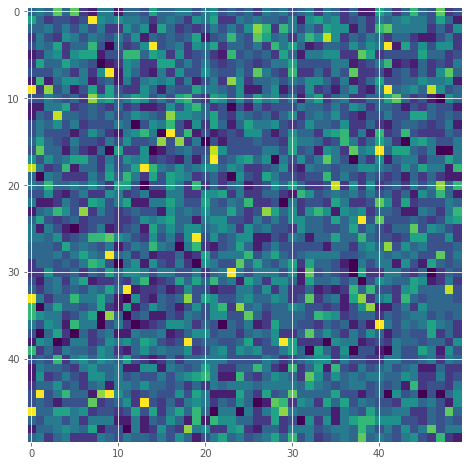

In [88]:
showField()

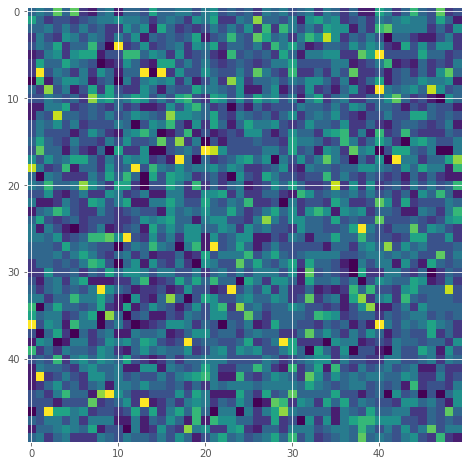

In [93]:
movePreds()
moveCarns()
showField()

---

### Применение Redis для выгрузки данных и синхронизации потоков

Попробуем выгрузить сайтов Lenta.ru и N+1 с использованием Redis в качестве центральной точки координирующей действия разных потоков работ (возможно, расположенных на разных компьютерах).  
У нас будет два потока для параллельного скачивания двух сайтов, один поток для разделения выгруженных текстов на слова, один поток для морфологического анализа, один поток для "применения" данных (получить и уничтожить).  
Каждый поток при запуске будет регистрироваться как исполнитель по данному виду работ. Далее он будет получать данные при помощи блокирующей операции от предыдущего этапа. Если получение данных не прошло за время таймаута, надо проверить, остались ли работники на предыдущем этапе. Если работников нет, необходимо прекратить свою работу и отчитаться об этом.

In [2]:
import json
import requests
import pymorphy2
import re
from bs4 import BeautifulSoup
from lxml import html
import multiprocessing

In [3]:
# Функция для загрузки одной новости из Ленты.ру
# def getLentaArticle(url):
#     """ getLentaArticle gets the body of the article from Lenta.ru"""
#     print("downloading lenta:", url)
#     r = requests.get(url)
#     p = BeautifulSoup(r.text, "html5")("p")
#     if len(p) == 0:
#         return "  "
#     p = " ".join([a.get_text() for a in p])
#     return p

def getArticleLenta(adr: str) -> str:
    ''' Загружает с сайта lenta.ru всю статью, задаваемую http-адресом adr.
    '''
    page = requests.get(adr)
    tree = html.fromstring(page.text)
    text = '\n'.join([p.text_content() for p in tree.xpath(".//div[@itemprop='articleBody']/p")])
    
    return text

def getDayArticles(r: redis.Redis, adr: str):
    ''' Загружает с сайта lenta.ru все статьи за день, задаваемый http-адресом adr.
    '''
    print('lenta '+adr)
    day = requests.get(adr)
    tree = html.fromstring(day.text)
    body = tree.xpath(".//a[@class='titles']")
    links = ['https://lenta.ru' + x.attrib["href"] for x in body]
    for link in links[:10]: # идем по первым 10 ссылкам на новости за день.
        news = getArticleLenta(link)
        if news != '':
            r.rpush("downloaded news", news)
        time.sleep(0.2)

# Функция загрузки одной новости из N+1.
def getArticleTextNPlus1(adr):
    print("downloading nplus1:", adr)
    r = requests.get(adr)
    n_text = re.split("</div>", re.split("</figure>", re.split('</article>',re.split('<article', r.text)[1])[0])[1])[1]    
    #return BeautifulSoup(n_text, "lxml").get_text()
    return BeautifulSoup(n_text, "html5").get_text()

# Загрузка новостей из Ленты.ру за некоторый период.
def getLenta():
    curdate = datetime.date(2017, 1, 16)
    findate = datetime.date(2017, 1, 16)
    res = ""
    
    redi = redis.Redis()
    redi.incrby("downloaders", 1)

# Загружаем новости до конечной даты.
    cnt = 0 # Очень скучно ждать, ограничим число новостей.
    while curdate <= findate:
        print('lenta ' + curdate.strftime('%Y/%m/%d'))
        getDayArticles(r, 'https://lenta.ru/news/' + curdate.strftime('%Y/%m/%d'))
        curdate += datetime.timedelta(days=1)
    redi.incrby("downloaders", -1)
    print("lenta finished")

# Получаем новости с NPlus1 за заданный промежуток времени, кладем тексты новостей в очередь qu.
# По завершении взводим семафор sem.
def getNplus1():
    curdate = datetime.date(2015, 12, 15)
    findate = datetime.date(2015, 12, 19)
    
    redi = redis.Redis()
    redi.incrby("downloaders", 1)
    cnt = 0
    while curdate <= findate: # Перебираем все дни.
        r = requests.get('https://nplus1.ru/news/'+curdate.strftime('%Y/%m/%d'))
        print('nplus ' + curdate.strftime('%Y/%m/%d'))
        # Берем заголовки и ссылки на новости за этот день.
        refs = [re.split('"', t)[6] for t in re.split('<article class="item item-news item-news', r.text)[1:]]
        for t in refs:
            news = getArticleTextNPlus1("https://nplus1.ru" + t)
            if news != "  ":
                redi.rpush("downloaded news", news)
            time.sleep(0.2) # Мы этичные хакеры и не стремимся к DDoS.
            cnt += 1
            if cnt > 10:
                break
        curdate += datetime.timedelta(days=1)
    redi.incrby("downloaders", -1)
    print("nplus1 finished")
    
# Функция токенизирует вход из очереди qu1 и кладет результаты токенизации в очередь qu2.
# Токенизация ведется до тех пор, пока семафор semw не будет взведен максимальное количество раз.
# По завершении токенизации устанавливаем событие evs.
def tokenize():  
    redi = redis.Redis()
    redi.incrby("tokenizers", 1)
    
    c = 0
    while True: 
        news = redi.blpop("downloaded news", 1)
        if news == None:
            nd = redi.get("downloaders")
            if int(nd) == 0:
                break
            else:
                continue
                
        c += 1
        print('tokenizer ' + str(c))
        res = [n[0] for n in re.findall("([А-Яа-я]+(-[А-Яа-я]+)*)", news[1].decode())]
        news = redi.rpush("tagged news", json.dumps(res))
        
    redi.incrby("tokenizers", -1)
    print("tokenization finished")

def lemmatize():
    redi = redis.Redis()
    redi.incrby("lemmatizers", 1)

    morpho = pymorphy2.MorphAnalyzer() # Создаем морфоанализатор.
    l = []
    c = 0
    while True: # Если событие установлено - пора завершать работу.
        news = redi.blpop("tagged news", 1)
        if news == None:
            nd = redi.get("tokenizers")
            if int(nd) == 0:
                break
            else:
                continue

        # blpop возвращает пару: имя списка, значение.
        txt = json.loads(news[1].decode())
        s = []
        for w in txt:
            s += morpho.parse(w)[0]
            
        res = json.dumps(str(s))
        redi.rpush("lemmatized news", res)
        c += 1
        print('lemma', c)
    redi.incrby("lemmatizers", -1)
    print("lemmatization finished")

# Функция имитирует, что она обрабатывает данные из очереди qu. Заершает работу по событию ev.    
def utilize():
    redi = redis.Redis()

    c = 0
    while True: # Если событие установлено - пора завершать работу.
        news = redi.blpop("lemmatized news", 1)
        if news == None:
            nd = redi.get("lemmatizers")
            if int(nd) == 0:
                break
            else:
                continue
                
        #processing
        c += 1
        print('process', c)
    print('processing finished')


In [4]:
r = redis.Redis()

In [5]:
r.flushdb()

True

In [9]:
r.set('downloaders', 0)
r.set('tokenizers', 0)
r.set('lemmatizers', 0)

lentap = multiprocessing.Process(target=getLenta)
nplusp = multiprocessing.Process(target=getNplus1)  
tokenp = multiprocessing.Process(target=tokenize)   
lemmap = multiprocessing.Process(target=lemmatize)   
processp = multiprocessing.Process(target=utilize)    


# Стартуем процессы    
lentap.start()
nplusp.start()
time.sleep(0.1)
tokenp.start()
time.sleep(0.1)
lemmap.start()
time.sleep(0.1)
processp.start()
show_redis_data(r)

# Если надо - ждем пока процессы не завершатся.
#lentap.join()
#nplusp.join()
#tokenp.join()
#lemmap.join()
#processp.join()
#print("Everything is allright")                               
                               

lenta 2017/01/16
lenta https://lenta.ru/news/2017/01/16
nplus 2015/12/15
downloading nplus1: https://nplus1.ru/news/2015/12/15/tastelikehumanist
tokenizer 1


HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">tokenizers</td><td style="padding:3px;w…

lemmaprocess  11

tokenizer 2
lemmaprocess  22

downloading nplus1: https://nplus1.ru/news/2015/12/15/soyuz-19m-success
tokenizer 3
processlemma  3
3
downloading nplus1: https://nplus1.ru/news/2015/12/15/new-particle
tokenizer 4
processlemma  4
4
tokenizer 5
lemmaprocess  55

downloading nplus1: https://nplus1.ru/news/2015/12/15/ocean-xprize
tokenizer 6
processlemma 6 
6
tokenizer 7
processlemma  77

downloading nplus1: https://nplus1.ru/news/2015/12/15/amegilla
tokenizer 8
lemmaprocess 8 8

tokenizer 9
lemmaprocess  99

downloading nplus1: https://nplus1.ru/news/2015/12/15/veggie
tokenizer 10
lemmaprocess  1010

tokenizer 11
processlemma  1111

downloading nplus1: https://nplus1.ru/news/2015/12/15/saar
tokenizer 12
lemmaprocess  1212

downloading nplus1: https://nplus1.ru/news/2015/12/15/lemurvocalisation
tokenizer 13
lemmaprocess  1313

tokenizer 14
lemmaprocess  1414

downloading nplus1: https://nplus1.ru/news/2015/12/15/engine
tokenizer 15
lemmaprocess  1515

tokenizer 16
processle

In [10]:
show_redis_data(r)

HTML(value='<table border="1"><tr><td style="padding:3px;width:150px;">tokenizers</td><td style="padding:3px;w…